# Case - Transformer
https://leemeng.tw/neural-machine-translation-with-transformer-and-tensorflow2.html#top

Copyright © 2019 Hsu Shih-Chieh


In [1]:
%load_ext autoreload
%autoreload 2
import os, csv, sys, shutil, warnings, joblib, glob, ntpath, hashlib, chardet, time
warnings.simplefilter("ignore")
from os import environ, listdir, makedirs, getcwd
from os.path import dirname, exists, expanduser, isdir, join, splitext
from collections import namedtuple
import numpy as np
import pandas as pd
from IPython.display import clear_output
from pprint import pprint
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import matplotlib as mpl
from datasets import load_newscommentary_v14
from utils import Transformer, create_masks

%matplotlib inline

Using TensorFlow backend.


### Load Data
- newscommentary_v14


In [2]:
data = load_newscommentary_v14(train_perc=80, val_prec=20)

print(data.DESCR)

W1014 10:44:33.168576 140529742518016 dataset_builder.py:689] Using custom data configuration zh-en


載入已建立的字典： /home/bigdata/MITEAM/Case_Practice/datasets/text/wmt2019/newscommentary_v14/en_vocab
字典大小：8188
前 10 個 subwords：[', ', 'the_', 'to_', 'of_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']
載入已建立的字典： /home/bigdata/MITEAM/Case_Practice/datasets/text/wmt2019/newscommentary_v14/zh_vocab
字典大小：4799
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']
preprocess...


### 建立模型
- padding mask
- look ahead mask
- multi-head
- scaled dot product attention 
- Encoder Layer / Decoder Layer
- positional_encoding
- Encoder / Decoder 
- Transfomer

In [3]:
num_layers = 4 
d_model = 128
dff = 512
num_heads = 8
input_vocab_size = data.subword_encoder_en.vocab_size + 2
target_vocab_size = data.subword_encoder_zh.vocab_size + 2
dropout_rate = 0.1  # 預設值

transformer = Transformer(num_layers, d_model, num_heads, dff, input_vocab_size, target_vocab_size, dropout_rate)



### loss function, config, training

In [4]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
def loss_function(real, pred):
    # 這次的 mask 將序列中不等於 0 的位置視為 1，其餘為 0 
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 照樣計算所有位置的 cross entropy 但不加總
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask  # 只計算非 <pad> 位置的損失 
    return tf.reduce_mean(loss_)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')




In [5]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  # 論文預設 `warmup_steps` = 4000
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
    
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)




In [6]:
# 方便比較不同實驗/ 不同超參數設定的結果
checkpoint_path = os.path.join('model/newscommentary_v14', "checkpoints")
log_dir = os.path.join('model/newscommentary_v14', 'logs')

run_id = f"{num_layers}layers_{d_model}d_{num_heads}heads_{dff}dff"
checkpoint_path = os.path.join(checkpoint_path, run_id)
log_dir = os.path.join(log_dir, run_id)

ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    last_epoch = int(ckpt_manager.latest_checkpoint.split("-")[-1])
    print(f'已讀取最新的 checkpoint，模型已訓練 {last_epoch} epochs。')
else:
    last_epoch = 0
    print("沒找到 checkpoint，從頭訓練。")

沒找到 checkpoint，從頭訓練。


In [7]:
@tf.function  # 讓 TensorFlow 幫我們將 eager code 優化並加快運算
def train_step(inp, tar):
    # 前面說過的，用去尾的原始序列去預測下一個字的序列
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    # 建立 3 個遮罩
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
  
    # 紀錄 Transformer 的所有運算過程以方便之後做梯度下降
    with tf.GradientTape() as tape:
        # 注意是丟入 `tar_inp` 而非 `tar`。記得將 `training` 參數設定為 True
        predictions, _ = transformer(inp, tar_inp, 
                                     True, 
                                     enc_padding_mask, 
                                     combined_mask, 
                                     dec_padding_mask)
        # 跟影片中顯示的相同，計算左移一個字的序列跟模型預測分佈之間的差異，當作 loss
        loss = loss_function(tar_real, predictions)

    # 取出梯度並呼叫前面定義的 Adam optimizer 幫我們更新 Transformer 裡頭可訓練的參數
    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # 將 loss 以及訓練 acc 記錄到 TensorBoard 上，非必要
    train_loss(loss)
    train_accuracy(tar_real, predictions)

In [8]:
EPOCHS = 200
print(f"此超參數組合的 Transformer 已經訓練 {last_epoch} epochs。")
print(f"剩餘 epochs：{min(0, last_epoch - EPOCHS)}")

summary_writer = tf.summary.create_file_writer(log_dir)

for epoch in range(last_epoch, EPOCHS):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
  
    # 一個 epoch 就是把我們定義的訓練資料集一個一個 batch 拿出來處理，直到看完整個數據集 
    for (step_idx, (inp, tar)) in enumerate(data.train):
        train_step(inp, tar)  

    # 每個 epoch 完成就存一次檔    
    if (epoch + 1) % 1 == 0:
        ckpt_save_path = ckpt_manager.save()
        print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
    # 將 loss 以及 accuracy 寫到 TensorBoard 上
    with summary_writer.as_default():
        tf.summary.scalar("train_loss", train_loss.result(), step=epoch + 1)
        tf.summary.scalar("train_acc", train_accuracy.result(), step=epoch + 1)
  
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))
    print('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

此超參數組合的 Transformer 已經訓練 0 epochs。
剩餘 epochs：-200
Saving checkpoint for epoch 1 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-1
Epoch 1 Loss 4.1437 Accuracy 0.0806
Time taken for 1 epoch: 150.3521866798401 secs

Saving checkpoint for epoch 2 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-2
Epoch 2 Loss 2.7642 Accuracy 0.2010
Time taken for 1 epoch: 64.60199904441833 secs

Saving checkpoint for epoch 3 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-3
Epoch 3 Loss 2.3684 Accuracy 0.2437
Time taken for 1 epoch: 65.73553824424744 secs

Saving checkpoint for epoch 4 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-4
Epoch 4 Loss 2.0700 Accuracy 0.2856
Time taken for 1 epoch: 58.931962728500366 secs

Saving checkpoint for epoch 5 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-5
Epoch 5 Loss 1.8324 Accuracy 0.3220
Time taken for 1 epoch: 58.97484087944031 secs

Saving ch

Saving checkpoint for epoch 44 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-44
Epoch 44 Loss 0.9641 Accuracy 0.4538
Time taken for 1 epoch: 56.64715623855591 secs

Saving checkpoint for epoch 45 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-45
Epoch 45 Loss 0.9609 Accuracy 0.4544
Time taken for 1 epoch: 60.03374934196472 secs

Saving checkpoint for epoch 46 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-46
Epoch 46 Loss 0.9579 Accuracy 0.4546
Time taken for 1 epoch: 56.5421404838562 secs

Saving checkpoint for epoch 47 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-47
Epoch 47 Loss 0.9549 Accuracy 0.4552
Time taken for 1 epoch: 59.98415660858154 secs

Saving checkpoint for epoch 48 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-48
Epoch 48 Loss 0.9519 Accuracy 0.4556
Time taken for 1 epoch: 59.82826495170593 secs

Saving checkpoint for epoch 49 at model/newsco

Saving checkpoint for epoch 87 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-87
Epoch 87 Loss 0.8831 Accuracy 0.4664
Time taken for 1 epoch: 59.82366490364075 secs

Saving checkpoint for epoch 88 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-88
Epoch 88 Loss 0.8814 Accuracy 0.4667
Time taken for 1 epoch: 56.39736723899841 secs

Saving checkpoint for epoch 89 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-89
Epoch 89 Loss 0.8806 Accuracy 0.4669
Time taken for 1 epoch: 56.55432367324829 secs

Saving checkpoint for epoch 90 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-90
Epoch 90 Loss 0.8796 Accuracy 0.4670
Time taken for 1 epoch: 56.632723569869995 secs

Saving checkpoint for epoch 91 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-91
Epoch 91 Loss 0.8783 Accuracy 0.4670
Time taken for 1 epoch: 56.59420347213745 secs

Saving checkpoint for epoch 92 at model/news

Saving checkpoint for epoch 130 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-130
Epoch 130 Loss 0.8467 Accuracy 0.4722
Time taken for 1 epoch: 56.41359996795654 secs

Saving checkpoint for epoch 131 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-131
Epoch 131 Loss 0.8463 Accuracy 0.4723
Time taken for 1 epoch: 56.333889961242676 secs

Saving checkpoint for epoch 132 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-132
Epoch 132 Loss 0.8453 Accuracy 0.4722
Time taken for 1 epoch: 59.68504524230957 secs

Saving checkpoint for epoch 133 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-133
Epoch 133 Loss 0.8457 Accuracy 0.4724
Time taken for 1 epoch: 56.198829889297485 secs

Saving checkpoint for epoch 134 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-134
Epoch 134 Loss 0.8438 Accuracy 0.4726
Time taken for 1 epoch: 56.52993583679199 secs

Saving checkpoint for epoch 

Saving checkpoint for epoch 173 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-173
Epoch 173 Loss 0.8255 Accuracy 0.4757
Time taken for 1 epoch: 59.74687719345093 secs

Saving checkpoint for epoch 174 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-174
Epoch 174 Loss 0.8250 Accuracy 0.4757
Time taken for 1 epoch: 56.342416524887085 secs

Saving checkpoint for epoch 175 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-175
Epoch 175 Loss 0.8243 Accuracy 0.4759
Time taken for 1 epoch: 56.59117007255554 secs

Saving checkpoint for epoch 176 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-176
Epoch 176 Loss 0.8233 Accuracy 0.4759
Time taken for 1 epoch: 56.54150700569153 secs

Saving checkpoint for epoch 177 at model/newscommentary_v14/checkpoints/4layers_128d_8heads_512dff/ckpt-177
Epoch 177 Loss 0.8242 Accuracy 0.4756
Time taken for 1 epoch: 56.287150382995605 secs

Saving checkpoint for epoch 

In [9]:
transformer.summary()

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  1841408   
_________________________________________________________________
decoder (Decoder)            multiple                  1672832   
_________________________________________________________________
dense_64 (Dense)             multiple                  619329    
Total params: 4,133,569
Trainable params: 4,133,569
Non-trainable params: 0
_________________________________________________________________


### Testing

In [10]:
MAX_LENGTH = 40
# 給定一個英文句子，輸出預測的中文索引數字序列以及注意權重 dict
def evaluate(inp_sentence):
    # 準備英文句子前後會加上的 <start>, <end>
    start_token = [data.subword_encoder_en.vocab_size]
    end_token = [data.subword_encoder_en.vocab_size + 1]

    # inp_sentence 是字串，我們用 Subword Tokenizer 將其變成子詞的索引序列
    # 並在前後加上 BOS / EOS
    inp_sentence = start_token + data.subword_encoder_en.encode(inp_sentence) + end_token
    encoder_input = tf.expand_dims(inp_sentence, 0)

    # 跟我們在影片裡看到的一樣，Decoder 在第一個時間點吃進去的輸入
    # 是一個只包含一個中文 <start> token 的序列
    decoder_input = [data.subword_encoder_zh.vocab_size]
    output = tf.expand_dims(decoder_input, 0)  # 增加 batch 維度

    # auto-regressive，一次生成一個中文字並將預測加到輸入再度餵進 Transformer
    for i in range(MAX_LENGTH):
        # 每多一個生成的字就得產生新的遮罩
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
            encoder_input, output)

        # predictions.shape == (batch_size, seq_len, vocab_size)
        predictions, attention_weights = transformer(encoder_input, 
                                                     output,
                                                     False,
                                                     enc_padding_mask,
                                                     combined_mask,
                                                     dec_padding_mask)


        # 將序列中最後一個 distribution 取出，並將裡頭值最大的當作模型最新的預測字
        predictions = predictions[: , -1:, :]  # (batch_size, 1, vocab_size)

        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 遇到 <end> token 就停止回傳，代表模型已經產生完結果
        if tf.equal(predicted_id, data.subword_encoder_zh.vocab_size + 1):
            return tf.squeeze(output, axis=0), attention_weights

        #將 Transformer 新預測的中文索引加到輸出序列中，讓 Decoder 可以在產生
        # 下個中文字的時候關注到最新的 `predicted_id`
        output = tf.concat([output, predicted_id], axis=-1)

    # 將 batch 的維度去掉後回傳預測的中文索引序列
    return tf.squeeze(output, axis=0), attention_weights

In [42]:
# 要被翻譯的英文句子
sentence = "Foxconn Technology Group is the world's largest provider of electronics manufacturing services"
    
# 取得預測的中文索引序列
predicted_seq, attention_weights = evaluate(sentence)

# 過濾掉 <start> & <end> tokens 並用中文的 subword tokenizer 幫我們將索引序列還原回中文句子
target_vocab_size = data.subword_encoder_zh.vocab_size
predicted_seq_without_bos_eos = [idx for idx in predicted_seq if idx < target_vocab_size]
predicted_sentence = data.subword_encoder_zh.decode(predicted_seq_without_bos_eos)

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("predicted_sentence:", predicted_sentence)

sentence: Foxconn Technology Group is the world's largest provider of electronics manufacturing services
--------------------
predicted_seq: tf.Tensor(
[4799  658  179  362  409  386  269    6   60  103  143   72   18    1
  522  316   88  258   95  444  196  137  301  414    3], shape=(25,), dtype=int32)
--------------------
predicted_sentence: 福克技术小组是全世界最大的电子制造业服务提供商。


### 注意力權重視覺化

In [43]:
#predicted_seq, attention_weights = evaluate(sentence)

# 在這邊我們自動選擇最後一個 Decoder layer 的 MHA 2，也就是 Decoder 關注 Encoder 的 MHA
layer_name = f"decoder_layer{num_layers}_block2"

print("sentence:", sentence)
print("-" * 20)
print("predicted_seq:", predicted_seq)
print("-" * 20)
print("attention_weights.keys():")
for layer_name, attn in attention_weights.items():
    print(f"{layer_name}.shape: {attn.shape}")
print("-" * 20)
print("layer_name:", layer_name)

sentence: Foxconn Technology Group is the world's largest provider of electronics manufacturing services
--------------------
predicted_seq: tf.Tensor(
[4799  658  179  362  409  386  269    6   60  103  143   72   18    1
  522  316   88  258   95  444  196  137  301  414    3], shape=(25,), dtype=int32)
--------------------
attention_weights.keys():
decoder_layer4_block1.shape: (1, 8, 25, 25)
decoder_layer4_block2.shape: (1, 8, 25, 26)
--------------------
layer_name: decoder_layer4_block2


In [44]:
zhfont = mpl.font_manager.FontProperties(fname='utils/fonts/NotoSansMonoCJKtc-Regular.otf')
plt.style.use("seaborn-whitegrid")

# 這個函式將英 -> 中翻譯的注意權重視覺化（注意：我們將注意權重 transpose 以最佳化渲染結果
def plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=None):
    fig = plt.figure(figsize=(15, 15))
    sentence = data.subword_encoder_en.encode(sentence)
    # 只顯示中文序列前 `max_len_tar` 個字以避免畫面太過壅擠
    if max_len_tar:
        predicted_seq = predicted_seq[:max_len_tar]
    else:
        max_len_tar = len(predicted_seq)
  
    # 將某一個特定 Decoder layer 裡頭的 MHA 1 或 MHA2 的注意權重拿出來並去掉 batch 維度
    attention_weights = tf.squeeze(attention_weights[layer_name], axis=0)  
    # (num_heads, tar_seq_len, inp_seq_len)
  
    # 將每個 head 的注意權重畫出
    for head in range(attention_weights.shape[0]):
        ax = fig.add_subplot(3, 3, head + 1)

        # [注意]我為了將長度不短的英文子詞顯示在 y 軸，將注意權重做了 transpose
        attn_map = np.transpose(attention_weights[head][:max_len_tar, :])
        ax.matshow(attn_map, cmap='viridis')  # (inp_seq_len, tar_seq_len)

        fontdict = {"fontproperties": zhfont}

        ax.set_xticks(range(max(max_len_tar, len(predicted_seq))))
        ax.set_xlim(-0.5, max_len_tar -1.5)

        ax.set_yticks(range(len(sentence) + 2))
        ax.set_xticklabels([data.subword_encoder_zh.decode([i]) for i in predicted_seq 
                            if i < data.subword_encoder_zh.vocab_size], 
                           fontdict=fontdict, fontsize=18)    

        ax.set_yticklabels(
            ['<start>'] + [data.subword_encoder_en.decode([i]) for i in sentence] + ['<end>'], 
            fontdict=fontdict)

        ax.set_xlabel('Head {}'.format(head + 1))
        ax.tick_params(axis="x", labelsize=12)
        ax.tick_params(axis="y", labelsize=12)

    plt.tight_layout()
    plt.show()
    plt.close(fig)

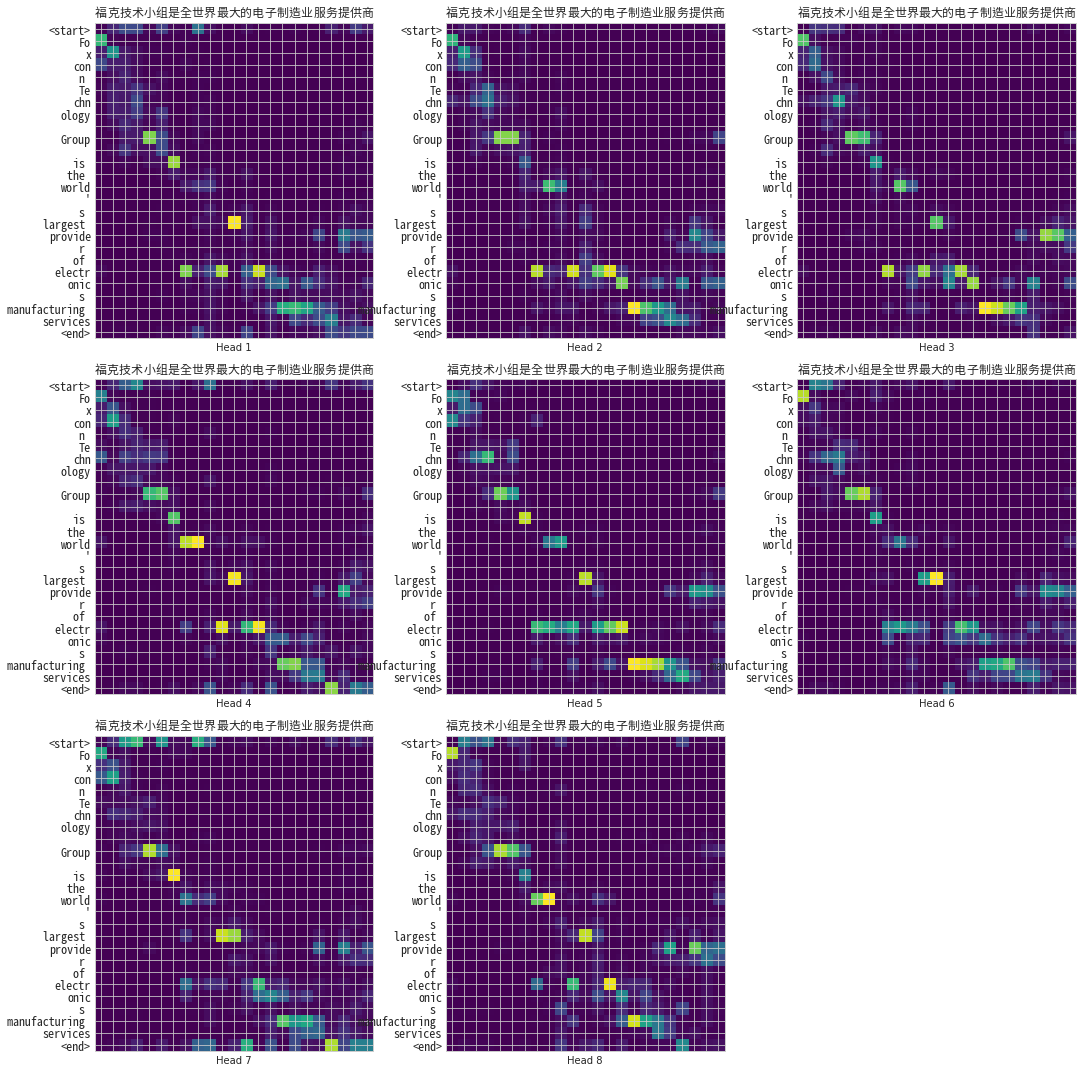

In [48]:
plot_attention_weights(attention_weights, sentence, predicted_seq, layer_name, max_len_tar=24)